# Q1. Round Trip

In [ ]:
from synkit.IO import rsmi_to_its, its_to_rsmi, smart_to_gml, gml_to_smart, load_database
from synkit.Chem.Reaction.standardize import Standardize
from synkit.Chem.Reaction.canon_rsmi import CanonRSMI
from synkit.Chem.Reaction.balance_check import BalanceReactionCheck
data = load_database('./Data/Benchmark/benchmark.json.gz')[:]
for value in data:
    try:
        check = BalanceReactionCheck().rsmi_balance_check(value['smart'])
        if check:
            smart = CanonRSMI().canonicalise(value['smart']).canonical_rsmi
            smart = Standardize().fit(smart, remove_aam=False)
            value['canon'] = smart
        else:
            value['canon'] = None

    except:
        value['canon'] = None
data = [value for value in data if value['canon']]

In [ ]:
from synkit.Graph.ITS.normalize_aam import NormalizeAAM

test = data[:].copy()
bug = []
for value in test:
    value['its'] = rsmi_to_its(value['canon'], core=False)
    value['canon_2'] = its_to_rsmi(value['its'])
    value['its_2'] = rsmi_to_its(value['canon_2'], core=False)
    value['gml'] = smart_to_gml(value['canon'], core=False, explicit_hydrogen=True)
    value['canon_3'] = NormalizeAAM().fit(gml_to_smart(value['gml']), fix_aam_indice=False)
    value['canon_3'] = CanonRSMI().canonicalise(value['canon_3']).canonical_rsmi
    try:
        value['gml_2'] = smart_to_gml(value['canon_3'], core=False, explicit_hydrogen=True)
    except:
        bug.append(value)

In [ ]:
from typing import Any, Dict, Iterable, List, Tuple

def round_trip_acc(
    data: Iterable[Dict[str, Any]],
    key_1: str,
    key_2: str,
    engine: str = "exact_match",
    backend: str = "nx",
) -> Tuple[float, List[int]]:
    eng = engine.lower()
    if eng in ("exact", "exact_match", "==", "exactmacth", "exact_macth"):
        eng = "exact_match"
    elif eng in ("iso", "isomorphic", "isomorphism"):
        eng = "isomorphic"
    else:
        raise ValueError(f"Unknown engine: {engine!r}")

    gm = None
    if eng == "isomorphic":
        try:
            from synkit.Graph.Matcher.graph_matcher import GraphMatcherEngine
        except Exception as e:
            raise ImportError("GraphMatcherEngine import failed; required for isomorphic engine.") from e
        gm = GraphMatcherEngine(backend=backend)

    total = 0
    matches = 0
    not_ok_indices: List[int] = []

    for idx, entry in enumerate(data):
        total += 1

        if key_1 not in entry or key_2 not in entry:
            not_ok_indices.append(idx)
            continue

        a = entry[key_1]
        b = entry[key_2]

        try:
            if eng == "exact_match":
                ok = (a == b)
            else:
                ok = bool(gm.isomorphic(a, b))
        except Exception:
            ok = False

        if ok:
            matches += 1
        else:
            not_ok_indices.append(idx)

    accuracy = (matches / total) if total > 0 else 0.0
    return accuracy, not_ok_indices


In [ ]:
accuracy, not_ok_indices = round_trip_acc(test, 'gml', 'gml_2', engine= 'exact', backend='nx')

In [ ]:
accuracy

# Q2+Q4

In [ ]:
from synkit.Graph.Feature.wl_hash import WLHash
from synkit.IO import rsmi_to_its
for value in data:
    value['wl_1'] = WLHash(iterations=1).weisfeiler_lehman_graph_hash(value['its']) 
    value['wl_2'] = WLHash(iterations=2).weisfeiler_lehman_graph_hash(value['its']) 
    value['wl_3'] = WLHash(iterations=3).weisfeiler_lehman_graph_hash(value['its']) 
    value['wl_4'] = WLHash(iterations=4).weisfeiler_lehman_graph_hash(value['its']) 
    value['wl_5'] = WLHash(iterations=5).weisfeiler_lehman_graph_hash(value['its']) 
    value['wl'] = WLHash().weisfeiler_lehman_graph_hash(value['its']) 

In [ ]:
from synkit.Graph.Matcher.graph_cluster import GraphCluster
cls = GraphCluster()
result = cls.fit(data, 'its', 'wl')

In [ ]:
from collections import OrderedDict
from typing import List, Dict, Any
from collections import OrderedDict
from typing import List, Dict, Any, Optional

def add_exact_match_classes(
    data: List[Dict[str, Any]],
    key: str = "wl",
    class_key: Optional[str] = None,
    inplace: bool = True,
    debug: bool = False,
) -> List[Dict[str, Any]]:
    """
    Add a numeric class label for exact-match clusters of `key` to each dict.

    - class_key defaults to f"{key}_class".
    - Labels are integers assigned in first-seen order (0, 1, 2, ...).
    - If inplace is False, the function works on shallow copies and returns the new list.
    - Returns the list of dicts (modified in-place or copies).
    - debug=True prints items that do not contain `key` (useful for diagnosing key mismatches).
    """
    if class_key is None:
        class_key = f"{key}_class"

    out = data if inplace else [dict(d) for d in data]

    value_to_id: "OrderedDict[Any, int]" = OrderedDict()
    next_id = 0
    for idx, item in enumerate(out):
        if debug and key not in item:
            # show actual keys to help debug e.g. whitespace / different punctuation
            print(f"[debug] item index {idx} missing key {repr(key)}; keys: {list(item.keys())}")
        val = item.get(key)  # returns None if key missing
        if val not in value_to_id:
            value_to_id[val] = next_id
            next_id += 1
        item[class_key] = value_to_id[val]

    return out


from collections import Counter, defaultdict
from typing import List, Dict, Any
import math

def clustering_metrics(
    data: List[Dict[str, Any]],
    pred_key: str,
    true_key: str,
) -> Dict[str, float]:
    """
    Compute cluster purity, Adjusted Rand Index (ARI), and Normalized Mutual Information (NMI).

    Args:
        data: list of dicts containing predicted and ground-truth labels
        pred_key: key in each dict for predicted cluster (can be hashable: int/str/etc.)
        true_key: key in each dict for ground-truth class/label

    Returns:
        dict with keys: 'purity', 'ari', 'nmi' (float; ARI/NMI come from scikit-learn).
        If `data` is empty, returns NaN for all metrics.
    """
    # collect labels (allow any hashable type)
    y_true = []
    y_pred = []
    for i, item in enumerate(data):
        # be tolerant: missing keys raise a clear error
        if true_key not in item:
            raise KeyError(f"missing ground-truth key '{true_key}' in item index {i}")
        if pred_key not in item:
            raise KeyError(f"missing predicted key '{pred_key}' in item index {i}")
        y_true.append(item[true_key])
        y_pred.append(item[pred_key])

    n = len(y_true)
    if n == 0:
        return {"purity": math.nan, "ari": math.nan, "nmi": math.nan}

    # Purity: for each predicted cluster, take majority true-label count
    clusters = defaultdict(list)
    for p, t in zip(y_pred, y_true):
        clusters[p].append(t)
    maj_count = 0
    for vals in clusters.values():
        c = Counter(vals)
        maj_count += c.most_common(1)[0][1]
    purity = maj_count / n

    # ARI and NMI via scikit-learn
    try:
        from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
    except Exception as exc:
        raise ImportError(
            "scikit-learn is required for ARI and NMI. Install it with: pip install scikit-learn"
        ) from exc

    ari = float(adjusted_rand_score(y_true, y_pred))
    nmi = float(normalized_mutual_info_score(y_true, y_pred))

    return {"purity": purity, "ari": ari, "nmi": nmi}



In [ ]:
out = add_exact_match_classes(result, key='wl_1', class_key='wl_1_class', inplace=False)
out = add_exact_match_classes(out, key='wl_2', class_key='wl_2_class', inplace=False)
out = add_exact_match_classes(out, key='wl_3', class_key='wl_3_class', inplace=False)
out = add_exact_match_classes(out, key='wl_4', class_key='wl_4_class', inplace=False)
out = add_exact_match_classes(out, key='wl_5', class_key='wl_5_class', inplace=False)

In [ ]:
metrics = []
check = ['wl_1_class', 'wl_2_class', 'wl_3_class', 'wl_4_class', 'wl_5_class']
for value in check:
    new = {'wl': value}
    r = clustering_metrics(out, value, 'class')
    new.update(r)
    metrics.append(new)

In [ ]:
from typing import List, Dict, Any, Optional, Tuple
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


class ClusterMetricsVisualizer:
    """
    Visualizer for clustering metrics across WL iterations.

    Provides a 1xN subplot grid (one axis per metric). Subplot titles are
    prefixed with panel labels (A., B., C., ...) instead of showing labels
    inside the plot area.

    :param dpi: DPI used when saving figures.
    :type dpi: int
    """

    def __init__(self, dpi: int = 200) -> None:
        self.dpi = int(dpi)
        self._df: Optional[pd.DataFrame] = None
        self._saved_paths: List[str] = []

    def __repr__(self) -> str:
        return (
            f"<ClusterMetricsVisualizer dpi={self.dpi} "
            f"has_dataframe={self._df is not None} saved_files={len(self._saved_paths)}>"
        )

    @staticmethod
    def _parse_index(series: pd.Series, pattern: str = r"wl_(\d+)_class") -> List[Optional[int]]:
        """Extract numeric index from strings like 'wl_1_class'; fallback to None."""
        rgx = re.compile(pattern)
        idxs: List[Optional[int]] = []
        for val in series:
            if isinstance(val, str):
                m = rgx.search(val)
                if m:
                    try:
                        idxs.append(int(m.group(1)))
                        continue
                    except ValueError:
                        pass
            idxs.append(None)
        return idxs

    def plot_subplots(
        self,
        data: List[Dict[str, Any]],
        x_key: str = "wl",
        metrics: Optional[List[str]] = None,
        figsize_per_plot: Tuple[float, float] = (4.0, 4.5),
        annotate_all: bool = True,
        sharey: bool = True,
        save_path: Optional[str] = None,
        palette: Optional[str] = None,
        font_family: str = "serif",
        panel_labels: Optional[List[str]] = None,
    ) -> "ClusterMetricsVisualizer":
        """
        Render a 1 x N subplot grid with one metric per axis.

        Panel letters are prefixed in each subplot title (A., B., C., ...).

        :param data: List of dicts containing x_key and metric keys.
        :type data: List[Dict[str, Any]]
        :param x_key: Key for x-axis labels (default: "wl").
        :type x_key: str
        :param metrics: Explicit list of metric keys to plot. If None, infer from data keys.
        :type metrics: Optional[List[str]]
        :param figsize_per_plot: Width,Height for each subplot; actual figure size is scaled by N.
        :type figsize_per_plot: Tuple[float, float]
        :param annotate_all: If True annotate every point in each subplot.
        :type annotate_all: bool
        :param sharey: Share y-axis across subplots for easier comparison.
        :type sharey: bool
        :param save_path: If provided, save the figure to this path.
        :type save_path: Optional[str]
        :param palette: Seaborn palette name (optional).
        :type palette: Optional[str]
        :param font_family: Font family to use (default: "serif").
        :type font_family: str
        :param panel_labels: Optional list of panel labels (e.g., ["A","B","C"]). If None uses A,B,C...
        :type panel_labels: Optional[List[str]]
        :returns: self
        :rtype: ClusterMetricsVisualizer
        """
        if not data:
            raise ValueError("`data` is empty.")

        df = pd.DataFrame(data)
        if x_key not in df:
            raise KeyError(f"x_key '{x_key}' not in data columns: {list(df.columns)}")

        if metrics is None:
            metrics = [c for c in df.columns if c != x_key]

        if not metrics:
            raise ValueError("No metrics to plot (empty or not inferred).")

        # numeric wl index extraction
        extracted = self._parse_index(df[x_key])
        if any(v is not None for v in extracted):
            df["_idx_tmp"] = [(v if v is not None else (i + 1)) for i, v in enumerate(extracted)]
        else:
            df["_idx_tmp"] = list(range(1, len(df) + 1))

        df = df.sort_values("_idx_tmp").reset_index(drop=True)
        df["wl_index"] = df["_idx_tmp"].astype(int)
        df[x_key] = df[x_key].astype(str)

        # numeric series map
        series_map = {}
        for m in metrics:
            if m not in df.columns:
                raise KeyError(f"Metric '{m}' not found in data.")
            series_map[m] = pd.to_numeric(df[m], errors="coerce")

        # persist dataframe
        self._df = df[[x_key, "wl_index"] + metrics].rename(columns={"_idx_tmp": "wl_index"})

        # plotting style
        sns.set_theme(style="whitegrid")
        if palette:
            sns.set_palette(palette)
        plt.rcParams.update({"font.family": font_family})

        n = len(metrics)
        fig_w = figsize_per_plot[0] * n
        fig_h = figsize_per_plot[1]
        fig, axes = plt.subplots(1, n, figsize=(fig_w, fig_h), sharey=sharey, squeeze=False)
        axes_row = axes[0]

        x = df["wl_index"].values
        max_idx = int(df["wl_index"].max())
        xticks = list(range(1, max_idx + 1))

        # prepare panel labels (A, B, C, ...)
        if panel_labels is None:
            alphabet = [f"{chr(ord('A') + i)}." for i in range(n)]
        else:
            if len(panel_labels) < n:
                raise ValueError("panel_labels length must be >= number of metrics")
            alphabet = [f"{lab}." for lab in panel_labels[:n]]

        ymin_all = df[metrics].min().min()
        ymax_all = df[metrics].max().max()
        if pd.isna(ymin_all) or pd.isna(ymax_all):
            ymin_all, ymax_all = 0.0, 1.0
        y_pad = max(1e-6, ymax_all - ymin_all)

        for idx, (ax, m) in enumerate(zip(axes_row, metrics)):
            y = series_map[m].values
            ax.plot(x, y, marker="o", linestyle="-", linewidth=2.0, markersize=6)
            # title prefixed with panel label and extra padding to separate from plot
            title_text = f"{alphabet[idx]} {m}"
            ax.set_title(title_text, fontsize=14, weight="medium", pad=12)
            ax.set_xticks(xticks)
            ax.set_xticklabels([str(i) for i in xticks], rotation=0, ha="center")
            ax.set_xlabel("WL iterations", fontsize=10)
            # y-limits with a bit of padding
            ax.set_ylim(max(0.0, ymin_all - 0.02 * y_pad), min(1.01, ymax_all + 0.02 * y_pad))
            ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)

            # annotate every point
            if annotate_all:
                for k in range(len(x)):
                    val = y[k]
                    if np.isnan(val):
                        continue
                    # offset above the marker (in points)
                    v_off = 6
                    ax.annotate(
                        f"{val:.4f}",
                        xy=(x[k], val),
                        xytext=(0, v_off),
                        textcoords="offset points",
                        ha="center",
                        va="bottom",
                        fontsize=8,
                        bbox=dict(boxstyle="round,pad=0.12", fc="white", ec="none", alpha=0.9),
                    )

        # shared y-label on the leftmost axis
        axes_row[0].set_ylabel("Metric value", fontsize=11)

        # Increase top margin so titles do not overlap with plot or get cramped.
        plt.tight_layout(rect=[0, 0, 0.98, 0.90])

        if save_path:
            save_dir = os.path.dirname(save_path) or "."
            os.makedirs(save_dir, exist_ok=True)
            fig.savefig(save_path, dpi=self.dpi)
            self._saved_paths = [save_path]
        else:
            self._saved_paths = []

        plt.show()
        plt.close(fig)
        return self

    @property
    def dataframe(self) -> Optional[pd.DataFrame]:
        """Return a copy of the last prepared DataFrame, if any."""
        return None if self._df is None else self._df.copy()

    @property
    def saved_paths(self) -> List[str]:
        """Return list of saved file paths from the last call (may be empty)."""
        return list(self._saved_paths)

# -------------------------
# Example usage
# -------------------------
if __name__ == "__main__":
    DATA = [
        {"wl": "wl_1_class", "purity": 0.99149300312091, "ari": 0.6293704266346963, "nmi": 0.9994246298256592},
        {"wl": "wl_2_class", "purity": 0.9997734823316219, "ari": 0.9859154872575924, "nmi": 0.9999851584208883},
        {"wl": "wl_3_class", "purity": 0.9999748313701802, "ari": 0.9984152133126427, "nmi": 0.9999983509574094},
        {"wl": "wl_4_class", "purity": 1.0, "ari": 1.0, "nmi": 1.0},
        {"wl": "wl_5_class", "purity": 1.0, "ari": 1.0, "nmi": 1.0},
    ]

    viz = ClusterMetricsVisualizer()
    viz.plot_subplots(
        DATA,
        x_key="wl",
        metrics=["purity", "ari", "nmi"],
        annotate_all=True,
        font_family="serif",
        save_path='wl_purity.pdf',
    )


# Q5

In [ ]:
from synkit.IO import rsmi_to_its, load_database
from synkit.Chem.Reaction.standardize import Standardize
from synkit.Chem.Reaction.canon_rsmi import CanonRSMI
from synkit.Graph.Feature.wl_hash import WLHash
data = load_database('./Data/Benchmark/benchmark.json.gz')[:]
for value in data:
    smart = CanonRSMI().canonicalise(value['smart']).canonical_rsmi
    smart = Standardize().fit(smart, remove_aam=False)
    value['canon'] = smart
    value['rc'] = rsmi_to_its(value['canon'], core=True)
    value['wl'] = WLHash().weisfeiler_lehman_graph_hash(value['rc'])

In [ ]:
from synkit.Graph.Matcher.graph_cluster import GraphCluster
cls = GraphCluster()
data = cls.fit(data, 'rc', 'wl')

In [ ]:
import pandas as pd
df = pd.DataFrame(data)
df['class'].value_counts()

In [ ]:
sample = [value for value in data if value['class']==7]
for value in sample:
    value['its'] = rsmi_to_its(value['canon'], core=False)
len(sample)

In [ ]:
import random
from typing import List, Dict, Any, Tuple, Optional

def random_split_80_20(
    data: List[Dict[str, Any]],
    seed: Optional[int] = None,
    shuffle: bool = True,
) -> Tuple[List[Dict[str, Any]], List[Dict[str, Any]]]:
    if not isinstance(data, list):
        raise TypeError("data must be a list")
    n = len(data)
    if n == 0:
        return [], []
    indices = list(range(n))
    rnd = random.Random(seed)
    if shuffle:
        rnd.shuffle(indices)
    n_train = int(0.8 * n)
    if n > 1 and n_train == 0:
        n_train = 1
    if n > 1 and n_train == n:
        n_train = n - 1
    train_idx = indices[:n_train]
    test_idx = indices[n_train:]
    return [data[i] for i in train_idx], [data[i] for i in test_idx]
train, test = random_split_80_20(sample, 42)

In [ ]:
from synkit.Graph.Context.hier_context import HierContext
demo, templates = HierContext(max_radius=5).fit(train, 'its')

In [ ]:
r0 = [value['K'] for value in templates[0]]
r1 = [value['K'] for value in templates[1]]
r2 = [value['K'] for value in templates[2]]
r3 = [value['K'] for value in templates[3]]
r4 = [value['K'] for value in templates[4]]
r5 = [value['K'] for value in templates[5]]

In [ ]:
len(r5)

In [ ]:
for value in test:
    rsmi = Standardize().fit(value['canon'], True)
    r, p = rsmi.split('>>')
    value['r'] = r
    value['p'] = p

In [ ]:
from synkit.Synthesis.Reactor.syn_reactor import SynReactor

from typing import List, Dict, Any, Iterable, Optional
import copy

def entry_process(
    entry: Dict[str, Any],
    rules: Iterable[Any],
    invert: bool = False,
    in_place: bool = False,
    raise_errors: bool = False,
    max_results: Optional[int] = None,
) -> Dict[str, Any]:
    if not isinstance(entry, dict):
        raise TypeError("entry must be a dict")
    if rules is None:
        return entry if in_place else copy.deepcopy(entry)

    out = entry if in_place else copy.deepcopy(entry)
    substrate_key = "p" if invert else "r"
    substrate = out.get(substrate_key)
    if substrate is None:
        return out

    results: List[Any] = []
    for i, r in enumerate(rules):
        try:
            reactor = SynReactor(
                substrate=substrate,
                template=r,
                automorphism=True,
                implicit_temp=False,
                explicit_h=True,
                invert=invert,
            )
            smarts = getattr(reactor, "smarts_list", None)
            if smarts:
                results.extend(smarts)
            if max_results is not None and len(results) >= max_results:
                results = results[:max_results]
                break
        except Exception as exc:
            if raise_errors:
                raise
            else:
                continue

    key = "bw" if invert else "fw"
    out[key] = results
    return out


In [ ]:
import time
import copy
from typing import List, Dict, Any, Tuple, Iterable, Callable, Optional

def timed_run(
    test: Iterable[Dict[str, Any]],
    rules: Iterable[Any],
    invert: bool = False,
    entry_fn: Optional[Callable[..., Dict[str, Any]]] = None,
) -> Tuple[float, List[Any], List[Dict[str, Any]]]:
    if entry_fn is None:
        from __main__ import entry_process as entry_fn  # fallback to imported symbol

    collected: List[Any] = []
    updated_test: List[Dict[str, Any]] = []
    key = "bw" if invert else "fw"

    t0 = time.time()
    for entry in test:
        # work on a copy to avoid unexpected external mutations
        entry_copy = copy.deepcopy(entry)
        res = entry_fn(entry_copy, rules=rules, invert=invert)

        # determine values produced by entry_fn and the updated entry to store
        if isinstance(res, dict):
            updated_entry = res
            vals = updated_entry.get(key)
            if vals is None:
                # ensure key exists even if entry_fn didn't set it
                updated_entry[key] = [] 
                vals = updated_entry[key]
        elif isinstance(res, list):
            vals = res
            updated_entry = copy.deepcopy(entry)
            updated_entry[key] = vals
        else:
            vals = [res]
            updated_entry = copy.deepcopy(entry)
            updated_entry[key] = vals

        # normalize vals to list and extend collected
        if isinstance(vals, list):
            collected.extend(vals)
        else:
            collected.append(vals)

        updated_test.append(updated_entry)

    elapsed = time.time() - t0
    return elapsed, updated_test


In [ ]:
import logging
from contextlib import contextmanager
from typing import Iterator

def disable_logging(level: int = logging.CRITICAL) -> int:
    prev = logging.getLogger().manager.disable
    logging.disable(level)
    return prev

def enable_logging(previous_level: int = 0) -> None:
    logging.disable(previous_level)

@contextmanager
def silence_logging(level: int = logging.CRITICAL) -> Iterator[None]:
    prev = disable_logging(level)
    try:
        yield
    finally:
        enable_logging(prev)

disable_logging()

In [ ]:
elapsed_0, collected_0 = timed_run(test[:], rules=r0, invert=False)
print('Done R0')
elapsed_1, collected_1 = timed_run(test[:], rules=r1, invert=False)
print('Done R1')
elapsed_2, collected_2 = timed_run(test[:], rules=r2, invert=False)
print('Done R2')
elapsed_3, collected_3 = timed_run(test[:], rules=r3, invert=False)
print('Done R3')
elapsed_4, collected_4 = timed_run(test[:], rules=r4, invert=False)
print('Done R4')
elapsed_5, collected_5 = timed_run(test[:], rules=r5, invert=False)
print('Done R5')

In [ ]:
for value in collected_0:
    value['rsmi'] = Standardize().fit(value['canon'], remove_aam=True)

for value in collected_1:
    value['rsmi'] = Standardize().fit(value['canon'], remove_aam=True)

for value in collected_2:
    value['rsmi'] = Standardize().fit(value['canon'], remove_aam=True)

for value in collected_3:
    value['rsmi'] = Standardize().fit(value['canon'], remove_aam=True)

for value in collected_4:
    value['rsmi'] = Standardize().fit(value['canon'], remove_aam=True)

for value in collected_5:
    value['rsmi'] = Standardize().fit(value['canon'], remove_aam=True)

In [ ]:
def clean(list_rsmi: List):
    new = []
    std = Standardize()
    for i in list_rsmi:
        i = std.fit(i)
        new.append(i)
    new = list(set(new))
    return new

In [ ]:
for value in collected_0:
    value['fw_clean'] = clean(value['fw'])

for value in collected_1:
    value['fw_clean'] = clean(value['fw'])

for value in collected_2:
    value['fw_clean'] = clean(value['fw'])

for value in collected_3:
    value['fw_clean'] = clean(value['fw'])

for value in collected_4:
    value['fw_clean'] = clean(value['fw'])

for value in collected_5:
    value['fw_clean'] = clean(value['fw'])

In [ ]:
from synkit.Synthesis.Metrics._base import _compute_metrics

m0 = _compute_metrics(collected_0, 'rsmi', 'fw_clean', beta=1)

In [ ]:
m1 =_compute_metrics(collected_1, 'rsmi', 'fw_clean',  beta=1)

In [ ]:
m2 =_compute_metrics(collected_2, 'rsmi', 'fw_clean',  beta=1)

In [ ]:
m3 =_compute_metrics(collected_3, 'rsmi', 'fw_clean',  beta=1)

In [ ]:
m4 =_compute_metrics(collected_4, 'rsmi', 'fw_clean',  beta=1)

In [ ]:
m5 =_compute_metrics(collected_5, 'rsmi', 'fw_clean',  beta=1)

In [ ]:
m5

In [ ]:
all = []
for i in range(6):
    r = globals().get(f"r{i}")
    elapsed = globals().get(f"elapsed_{i}")
    m = globals().get(f"m{i}", {}) or {}
    n = len(r) if (r is not None and hasattr(r, "__len__")) else None
    all.append({
        "radii": i,
        "n": n,
        "time": float(elapsed) if elapsed is not None else None,
        "recall": m.get("Coverage"),
        "precision": m.get("Recognition"),
        "F1": m.get("F1_score"),
    })


In [ ]:
all

In [120]:
from typing import List, Dict, Any, Optional, Tuple
import matplotlib.pyplot as plt


def _prep(data: List[Dict[str, Any]]) -> Tuple[list, list, list, list, list, list]:
    d = sorted(data, key=lambda v: int(v["radii"]))
    xs = [int(v["radii"]) for v in d]
    rec = [float(v.get("recall", 0.0)) for v in d]
    pre = [float(v.get("precision", 0.0)) for v in d]
    f1 = [float(v.get("F1", 0.0)) for v in d]
    t = [float(v.get("time", 0.0)) for v in d]
    n = [int(v.get("n", 0)) for v in d]
    return xs, rec, pre, f1, t, n


def _annot_series(ax, xs, ys, dy=8, fmt="{:.2f}", fontsize=9):
    for x, y in zip(xs, ys):
        ax.annotate(fmt.format(y), (x, y), xytext=(0, dy),
                    textcoords="offset points", ha="center", fontsize=fontsize)


# ---------- manuscript-ready (annotated) ----------
def plot_metrics_time_counts(
    data: List[Dict[str, Any]],
    title: Optional[str] = None,
    save_path: Optional[str] = None,
    show: bool = True,
    show_values: bool = True,
    log_time: bool = False,
) -> plt.Figure:
    """
    Plot recall/precision/F1 (left axis), time (right axis) and counts (outer-right bars).
    :param title: Optional plot title.
    :param show_values: Annotate numeric values on the figure (metrics, time, counts).
    """
    xs, rec, pre, f1, times, counts = _prep(data)

    fig, ax_l = plt.subplots(figsize=(10.5, 5.6))

    l1, = ax_l.plot(xs, rec, marker="o", linewidth=2.2, label="recall")
    l2, = ax_l.plot(xs, pre, marker="o", linewidth=2.2, label="precision")
    l3, = ax_l.plot(xs, f1,  marker="o", linewidth=2.2, label="F1")
    ax_l.set_xlabel("radii")
    ax_l.set_ylabel("score")
    ax_l.set_xticks(xs)
    ax_l.set_ylim(-0.02, 1.02)
    ax_l.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.55)

    ax_t = ax_l.twinx()
    l4, = ax_t.plot(xs, times, marker="s", linestyle="--", linewidth=1.8, label="time (s)")
    ax_t.set_ylabel("time (s)")
    if log_time:
        ax_t.set_yscale("log")
    ax_t.set_ylim((0 if not log_time else None), max(times) * (1.15 if times else 1.0))

    ax_c = ax_l.twinx()
    ax_c.spines["right"].set_position(("axes", 1.12))
    bars = ax_c.bar(xs, counts, width=0.5, alpha=0.22, label="n (count)", align="center")
    ax_c.set_ylim(0, max(counts) * 1.12 if counts else 1)
    ax_c.set_ylabel("n (count)")

    # title
    if title:
        ax_l.set_title(title, fontsize=14, pad=12)

    # legend (single row bottom)
    handles = [l1, l2, l3, l4, bars]
    labels = [h.get_label() for h in handles]
    ax_l.legend(handles, labels, loc="upper center",
                bbox_to_anchor=(0.5, -0.18), ncol=5, frameon=False)

    # show numeric values if requested
    if show_values:
        _annot_series(ax_l, xs, rec, dy=8, fmt="{:.2f}")
        _annot_series(ax_l, xs, pre, dy=18, fmt="{:.2f}")
        _annot_series(ax_l, xs, f1,  dy=28, fmt="{:.2f}")
        for x, y in zip(xs, times):
            txt = f"{y:.1f}s" if y >= 1 else f"{y:.2f}s"
            ax_t.annotate(txt, (x, y), xytext=(0, -12), textcoords="offset points", ha="center", fontsize=9)
        for r in bars:
            h = r.get_height()
            ax_c.annotate(f"{int(h)}", (r.get_x() + r.get_width()/2, h),
                          xytext=(0, 4), textcoords="offset points", ha="center", fontsize=9)

    fig.tight_layout(rect=[0, 0, 1, 0.94])
    if save_path:
        fig.savefig(save_path, dpi=220, bbox_inches="tight")
    if show:
        plt.show()
    return fig


# ---------- compact variant ----------
def plot_metrics_time_counts_compact(
    data: List[Dict[str, Any]],
    title: Optional[str] = None,
    save_path: Optional[str] = None,
    show: bool = True,
    show_values: bool = False,
) -> plt.Figure:
    """
    Compact plot: stronger lines, fewer annotations by default.
    :param title: Optional plot title.
    :param show_values: Whether to annotate numeric values.
    """
    xs, rec, pre, f1, times, counts = _prep(data)
    fig, ax = plt.subplots(figsize=(9.5, 4.8))

    l1, = ax.plot(xs, rec, marker="o", linewidth=2.6, label="recall")
    l2, = ax.plot(xs, pre, marker="o", linewidth=2.6, label="precision")
    l3, = ax.plot(xs, f1,  marker="o", linewidth=2.6, label="F1")
    ax.set_xlabel("radii")
    ax.set_ylabel("score")
    ax.set_ylim(0, 1.02)
    ax.set_xticks(xs)
    ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.55)

    ax_t = ax.twinx()
    l4, = ax_t.plot(xs, times, marker="s", linestyle="--", linewidth=2.0, label="time (s)")
    ax_t.set_ylabel("time (s)")

    ax_c = ax.twinx()
    ax_c.spines["right"].set_position(("axes", 1.1))
    bars = ax_c.bar(xs, counts, width=0.45, alpha=0.22, label="n (count)")
    ax_c.set_ylabel("n (count)")

    if title:
        ax.set_title(title, fontsize=13, pad=10)

    ax.legend([l1, l2, l3, l4, bars], ["recall", "precision", "F1", "time (s)", "n (count)"],
              loc="upper center", bbox_to_anchor=(0.5, -0.16), ncol=5, frameon=False)

    if show_values:
        _annot_series(ax, xs, rec, dy=8, fmt="{:.2f}")
        _annot_series(ax, xs, pre, dy=18, fmt="{:.2f}")
        _annot_series(ax, xs, f1,  dy=28, fmt="{:.2f}")
        for x, y in zip(xs, times):
            ax_t.annotate(f"{y:.1f}s", (x, y), xytext=(0, -12), textcoords="offset points", ha="center", fontsize=9)
        for r in bars:
            h = r.get_height()
            ax_c.annotate(f"{int(h)}", (r.get_x() + r.get_width()/2, h),
                          xytext=(0, 4), textcoords="offset points", ha="center", fontsize=9)

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    if save_path:
        fig.savefig(save_path, dpi=220, bbox_inches="tight")
    if show:
        plt.show()
    return fig


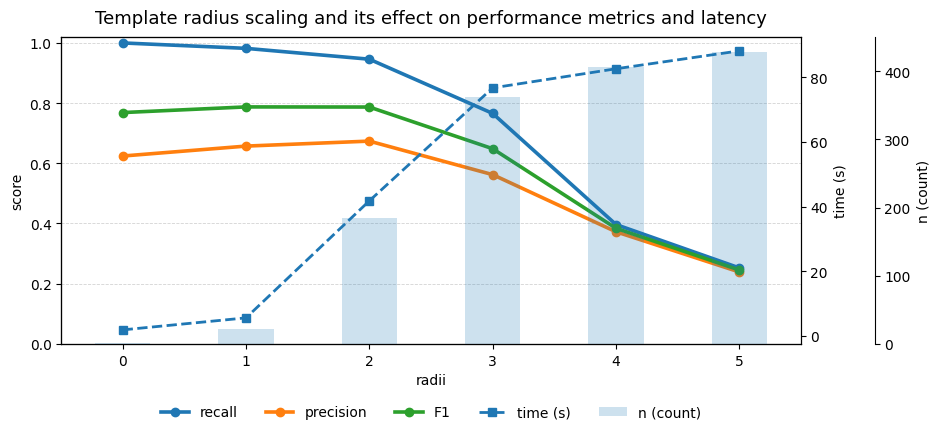

In [125]:
# Example:
figs = plot_metrics_time_counts_compact(all, save_path="radii_summary.pdf", show=True, title='Template radius scaling and its effect on performance metrics and latency')

In [116]:
all

[{'radii': 0,
  'n': 1,
  'time': 1.7876200675964355,
  'recall': 1.0,
  'precision': 0.6241241241241241,
  'F1': 0.7685670261941449},
 {'radii': 1,
  'n': 22,
  'time': 5.5116286277771,
  'recall': 0.9819819819819819,
  'precision': 0.6571571571571572,
  'F1': 0.787384636544942},
 {'radii': 2,
  'n': 184,
  'time': 41.74665427207947,
  'recall': 0.9459459459459459,
  'precision': 0.6737237237237237,
  'F1': 0.7869582756020135},
 {'radii': 3,
  'n': 363,
  'time': 76.7340133190155,
  'recall': 0.7657657657657657,
  'precision': 0.5623123123123124,
  'F1': 0.648455125560835},
 {'radii': 4,
  'n': 407,
  'time': 82.6573269367218,
  'recall': 0.3963963963963964,
  'precision': 0.37237237237237236,
  'F1': 0.384009009009009},
 {'radii': 5,
  'n': 429,
  'time': 88.19999122619629,
  'recall': 0.25225225225225223,
  'precision': 0.23873873873873871,
  'F1': 0.24530952971319941}]